# Finding Points of Interest

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from src.tools.cache import cache_np

from src.data.traceloader import AscadRandomKey, TraceGroup

sns.set_style("whitegrid")

In [2]:
ascad = AscadRandomKey()
ascad.default.profile.traces.shape

(200000, 1400)

### Order difference detection tool

In [3]:
def calc_moment_difference(tg: TraceGroup, moment=1, use_attack=False):
    kr = range(ascad.key_size)
    stat_moment = lambda a: stats.moment(a, moment=moment, axis=0, nan_policy='raise')

    if use_attack:
        traces_left = [stat_moment(tg.profile.filter_by_key(k)) for k in kr]
        traces_right = [stat_moment(tg.attack.filter_by_key(k)) for k in kr]
    else:
        traces_left, traces_right = [], []
        tc = tg.profile

        for k in kr:
            traces = tc.filter_by_key(k)
            mid = round(len(traces) / 2)
            traces_left.append(stat_moment(traces[mid:]))
            traces_right.append(stat_moment(traces[:mid]))

    cross = []
    for i in kr:
        for j in kr:
            if i != j:
                cross.append(abs(traces_left[i] - traces_right[j]))

    mean_diff_neq = np.mean(cross, axis=0)
    mean_diff_eq = np.mean([abs(traces_left[i] - traces_right[i]) for i in kr], axis=0)

    return mean_diff_neq - mean_diff_eq

def get_moment_differences(db, use_attack=False, trace_size=ascad.trace_len, max_moment=3):
    mdiff = [calc_moment_difference(db.default, i, use_attack) for i in range(1, max_moment + 1)]

    return np.array([np.zeros(trace_size), *mdiff])

MOMENT_DIFFERENCES = cache_np("moment_differences", get_moment_differences, ascad, v=4)
TRUE_MDIFF = cache_np("true_moment_differences", get_moment_differences, ascad, True, v=4)

# TODO try window = 100, strange result.
def select_poi(moment_difference, n=5, window=15):
    """
    Selects the top n most interesting points of interest, based on some statistical moment difference.
    """
    diff = abs(moment_difference)
    std = np.std(diff)
    ts = [*(diff > std), *([False] * window)]

    acc = []
    counter, sum_diff, max_diff = 0, 0.0, 0.0
    for ix in range(len(ts)):
        if ts[ix]:
            counter += 1
            sum_diff += diff[ix]
            max_diff = max(diff[ix], max_diff)

        elif counter >= window:
            avg_diff = sum_diff / counter
            acc.append((ix - counter, ix, avg_diff))
            counter, sum_diff, max_diff = 0, 0.0, 0.0

    if len(acc) == 0:
        return []

    return pd.DataFrame(acc).sort_values(2, ascending=False).head(n)[[0,1]].values

In [4]:
select_poi(MOMENT_DIFFERENCES[1])

array([[ 804,  831],
       [  50,   74],
       [ 429,  447],
       [1303, 1319],
       [ 179,  194]])

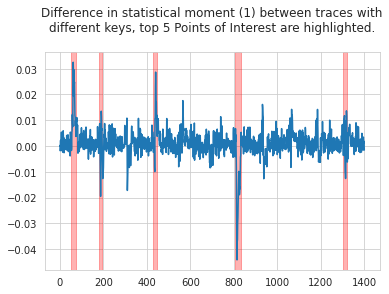

In [7]:
def plot_poi(mdiff, moment):
    fig, ax = plt.subplots()
    top_n = 5

    title = f"Difference in statistical moment ({moment}) between traces with\ndifferent keys, " \
            f"top {top_n} Points of Interest are highlighted.\n"
    sns.lineplot(data=mdiff[moment]).set_title(title)

    for a, b in select_poi(mdiff[moment], top_n):
        ax.axvspan(a, b, alpha=0.3, color='red')

    plt.show()

plot_poi(MOMENT_DIFFERENCES, 1)